# Linear Classification and Stochastic Gradient Descent

## 1. Load the training set and validation set.
Import necessary packages and set parameters.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.datasets import load_svmlight_file

# paremeters
epoch = 2
batch_size = 128

Load the training set and validation set.

In [25]:
def get_data(data_path, n_features):
    X, y = load_svmlight_file(data_path, n_features=n_features)
    X = X.toarray()
    b = np.ones((X.shape[0], 1))
    X = np.concatenate((b, X), axis=1)
    y = np.expand_dims(y, axis=1)
    return X, y

train_data_path = './a9a'
val_data_path = './a9a.t'
X_train, y_train = get_data(train_data_path, n_features=123)
X_val, y_val = get_data(val_data_path, n_features=123)

print('Training data set contains {} examples with {} dimensions'.format(X_train.shape[0], X_train.shape[1]))
print('Validation data set contains {} examples with {} dimensions'.format(X_val.shape[0], X_val.shape[1]))

Training data set contains 32561 examples with 124 dimensions
Validation data set contains 16281 examples with 124 dimensions


## 2. Initalize SVM model parameters
Initalize SVM model parameters using normal distribution.

In [26]:
W1 = np.random.randn(X_train.shape[1], 1)
W2 = np.copy(W1)
W3 = np.copy(W1)
W4 = np.copy(W1)
W5 = np.copy(W1)

## 3. Optimization
Define function to plot loss and error.

In [27]:
def plot_loss(train_loss, test_loss):
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='train', linewidth=2.0)
    ax.plot(test_loss, label='validation', linewidth=2.0)
    ax.set(xlabel='Iteration', ylabel='Loss')
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()
    
def plot_error(val_loss):
    fig, ax = plt.subplots()
    ax.plot(val_loss, linewidth=2.0)
    ax.set(xlabel='Iteration', ylabel='Error')
    ax.grid()
    plt.show()

### 3.1 Update model parameters using SGD
#### SVM loss function:
$$L = \frac{1}{N} \sum_{i = 1}^N \left[ \frac{\lambda}{2} \Vert W \Vert^2 + \max(0, 1 - y_iW^T x_i) \right]$$
#### The gradient with respect to the weight:
$$g = 
\begin{cases}
\frac{1}{N} \sum_{i=1}^{N} \lambda W& y_iW^T x_i > 1\\
\frac{1}{N} \sum_{i=1}^{N} \left[\lambda W - x_i^T y_i\right] & y_iW^T x_i \leq 1
\end{cases}$$
#### Using SGD to update the weight:
$$W_{t+1} = W_t - \eta \cdot g ,$$
where the positive scalar $\eta$ is the learning rate.

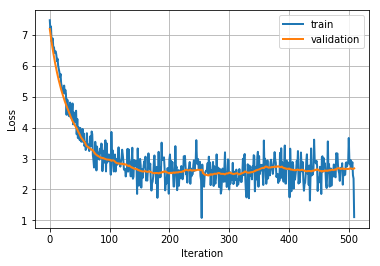

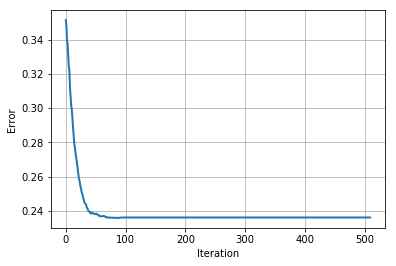

In [28]:
def SGD_train(X_train, y_train, X_val, y_val, W):
    eta = 0.1
    lbda = 0.1
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    val_error = np.zeros((epoch * num_batch, ))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(num_batch):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            condition = y_train_batch * (X_train_batch.dot(W))
            val_condition = y_val * (X_val.dot(W))
            train_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - condition)) / batch_size
            val_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - val_condition)) / val_n
            val_error[i * num_batch + j] = np.where(val_condition < 0)[0].size / val_n
            W_grad = lbda * batch_size * W - X_train[np.where(condition <= 1)[0], :].T.dot(y_train[np.where(condition <= 1)[0], :])
            W_grad = W_grad / batch_size
            W = W - eta * W_grad
    return train_loss, val_loss, val_error

train_loss, val_loss, val_error = SGD_train(X_train, y_train, X_val, y_val, W1)
plot_loss(train_loss, val_loss)
plot_error(val_error)

### 3.2 Update model parameters using NAG
$$v_t = \gamma v_{t-1} + \eta \cdot \frac{\partial{L}}{\partial{(W - \gamma v_{t-1})}} $$
$$W_{t+1} = W_t - v_t$$
$\eta$ is the learning rate.

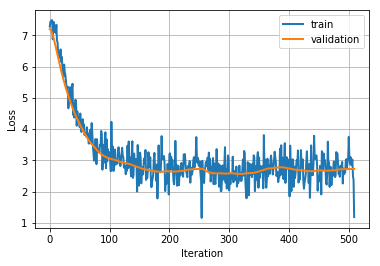

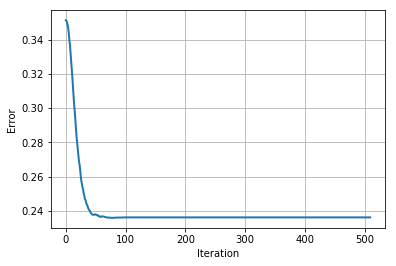

In [29]:
def NAG_train(X_train, y_train, X_val, y_val, W):
    eta = 0.01
    lbda = 0.1
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    v = np.zeros((dim, 1))
    momentum = 0.9
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    val_error = np.zeros((epoch * num_batch, ))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(num_batch):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            condition = y_train_batch * (X_train_batch.dot(W))
            val_condition = y_val * (X_val.dot(W))
            train_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - condition)) / batch_size
            val_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - val_condition)) / val_n
            val_error[i * num_batch + j] = np.where(val_condition < 0)[0].size / val_n
            W_new = W - momentum * v
            W_grad = lbda * batch_size * W_new - X_train[np.where(condition <= 1)[0], :].T.dot(y_train[np.where(condition <= 1)[0], :])
            W_grad = W_grad / batch_size
            v = momentum * v + eta * W_grad
            W = W - v
    return train_loss, val_loss, val_error


train_loss, val_loss, val_error = NAG_train(X_train, y_train, X_val, y_val, W2)
plot_loss(train_loss, val_loss)
plot_error(val_error)

### 3.3 Update model parameters using RmsProp
$$E[g^2]_t = 0.9E[g^2]_{t - 1} + 0.1g_t^2$$
$$W_{t+1} = W_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t$$
$\eta$ is the learning rate.

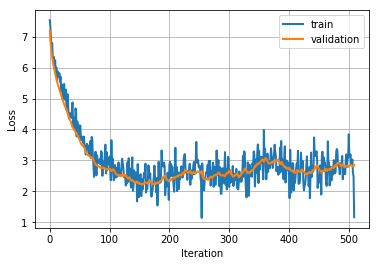

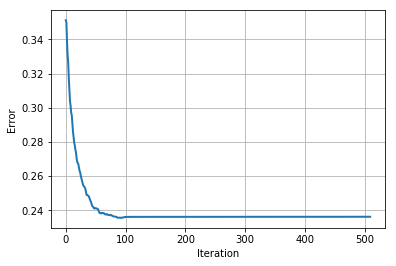

In [30]:
def RMSprop_train(X_train, y_train, X_val, y_val, W):
    eta = 0.01
    lbda = 0.1
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    val_error = np.zeros((epoch * num_batch, ))
    E_grad = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(num_batch):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            condition = y_train_batch * (X_train_batch.dot(W))
            val_condition = y_val * (X_val.dot(W))
            train_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - condition)) / batch_size
            val_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - val_condition)) / val_n
            val_error[i * num_batch + j] = np.where(val_condition < 0)[0].size / val_n
            W_grad = lbda * batch_size * W - X_train[np.where(condition <= 1)[0], :].T.dot(y_train[np.where(condition <= 1)[0], :])
            W_grad = W_grad / batch_size
            E_grad = 0.9 * E_grad + 0.1 * np.square(W_grad)
            W = W - eta / np.sqrt(E_grad + np.spacing(1)) * W_grad
    return train_loss, val_loss, val_error

train_loss, val_loss, val_error = RMSprop_train(X_train, y_train, X_val, y_val, W3)
plot_loss(train_loss, val_loss)
plot_error(val_error)

### 3.4 Update model parameters using Adadelta
$$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g_t^2$$
$$RMS[g]_t = \sqrt{E[g^2]_t + \epsilon}$$
$$\Delta W_t = - \frac{\eta}{RMS[g]_t} g_t$$
$$E[\Delta W^2]_t = \gamma E[\Delta W^2]_{t-1} + (1 - \gamma) \Delta W_t^2$$
$$RMS[\Delta W]_t = \sqrt{E[\Delta W^2]_t + \epsilon}$$
$$\Delta W_t = - \frac{RMS[\Delta W]_{t-1}}{RMS[g]_t}g_t $$
$$W = W + \Delta W$$
$\eta$ is the learning rate.

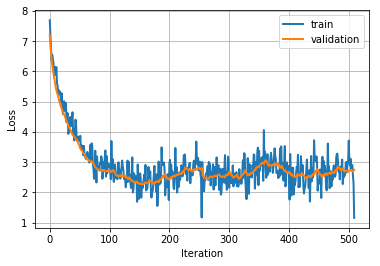

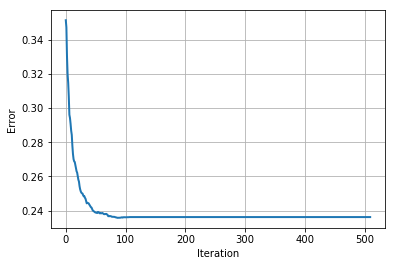

In [31]:
def AdaDelta_train(X_train, y_train, X_val, y_val, W):
    eta = 0.01
    lbda = 0.1
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    val_error = np.zeros((epoch * num_batch, ))
    momentum = 0.9
    E_grad = np.zeros((dim, 1))
    E_delta_W = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(num_batch):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            condition = y_train_batch * (X_train_batch.dot(W))
            val_condition = y_val * (X_val.dot(W))
            train_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - condition)) / batch_size
            val_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - val_condition)) / val_n
            val_error[i * num_batch + j] = np.where(val_condition < 0)[0].size / val_n
            W_grad = lbda * batch_size * W - X_train[np.where(condition <= 1)[0], :].T.dot(y_train[np.where(condition <= 1)[0], :])
            W_grad = W_grad / batch_size
            E_grad = momentum * E_grad + (1 - momentum) * np.square(W_grad)
            RMS_grad = np.sqrt(E_grad + np.spacing(1))
            delta_W = - eta / RMS_grad * W_grad
            E_delta_W = momentum * E_delta_W + (1 - momentum) * np.square(delta_W)
            RMS_delta_W = np.sqrt(E_delta_W + np.spacing(1))
            W = W - RMS_delta_W / RMS_grad * W_grad
    return train_loss, val_loss, val_error

train_loss, val_loss, val_error = AdaDelta_train(X_train, y_train, X_val, y_val, W4)
plot_loss(train_loss, val_loss)
plot_error(val_error)

### 3.5 Update model parameters using Adam
$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
$$v_t = \beta_2v_{t-1} + (1-\beta_2)g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$W_{t+1} = W_t - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}} \hat{m}_t$$
$\eta$ is the learning rate.

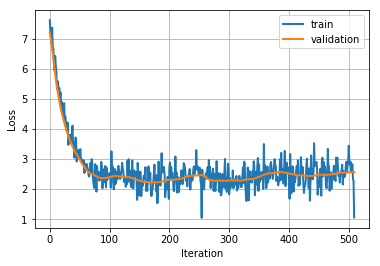

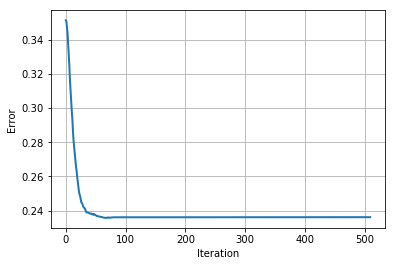

In [32]:
def Adam_train(X_train, y_train, X_val, y_val, W):
    alpha = 0.01
    lbda = 0.1
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    val_error = np.zeros((epoch * num_batch, ))
    beta_1 = 0.9
    beta_2 = 0.999
    m = np.zeros((dim, 1))
    v = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(num_batch):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            condition = y_train_batch * (X_train_batch.dot(W))
            val_condition = y_val * (X_val.dot(W))
            train_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - condition)) / batch_size
            val_loss[i * num_batch + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - val_condition)) / val_n
            val_error[i * num_batch + j] = np.where(val_condition < 0)[0].size / val_n
            W_grad = lbda * batch_size * W - X_train[np.where(condition <= 1)[0], :].T.dot(y_train[np.where(condition <= 1)[0], :])
            m = beta_1 * m + (1 - beta_1) * W_grad
            v = beta_2 * v + (1 - beta_2) * np.square(W_grad)
            m_hat = m / (1 - beta_1)
            v_hat = v / (1 - beta_2)
            W = W - alpha / (np.sqrt(v_hat) + np.spacing(1)) * m_hat
    return train_loss, val_loss, val_error

train_loss, val_loss, val_error = Adam_train(X_train, y_train, X_val, y_val, W5)
plot_loss(train_loss, val_loss)
plot_error(val_error)

## 4. Investigate the sensitiveness of the parametes
### 4.1 Investigate the sensitiveness of $\eta$ with SGD

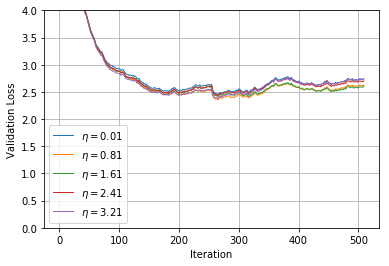

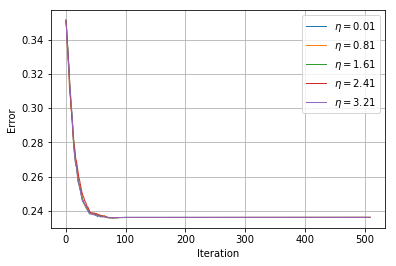

In [66]:
epoch = 2
batch_size = 128
lbda = 0.1
eta_list = np.arange(0.01, 4, 0.8)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
ax.set_ylim(0, 4)

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Error')
ax2.grid()
line_list = []
line_list_2 = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss, val_error = SGD_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_2, = ax2.plot(val_error, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_list.append(line)
    line_list_2.append(line)
ax.legend(handles=line_list)
ax2.legend(handles=line_list_2)
plt.show()
fig.savefig('figures/loss_vs_iteation_SGD_linear_classification.pdf')
fig2.savefig('figures/error_vs_iteation_SGD_linear_classification.pdf')

### 4.2 Investigate the sensitiveness of $\eta$ with NAG

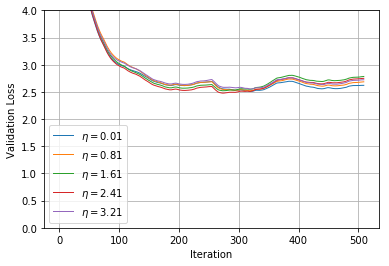

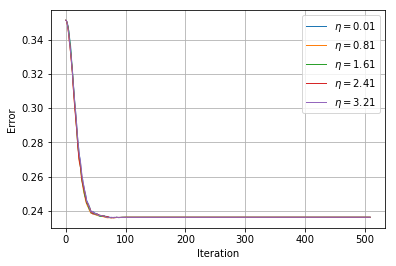

In [62]:
epoch = 2
batch_size = 128
lbda = 0.1
eta_list = np.arange(0.01, 4, 0.8)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
ax.set_ylim(0, 4)

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Error')
ax2.grid()
line_list = []
line_list_2 = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss, val_error = NAG_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_2, = ax2.plot(val_error, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_list.append(line)
    line_list_2.append(line)
ax.legend(handles=line_list)
ax2.legend(handles=line_list_2)
plt.show()
fig.savefig('figures/loss_vs_iteation_with_NAG_linear_classification.pdf')
fig2.savefig('figures/error_vs_iteation_NAG_linear_classification.pdf')

### 4.3 Investigate the sensitiveness of $\eta$ with RmsProp

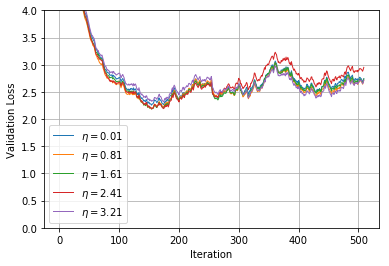

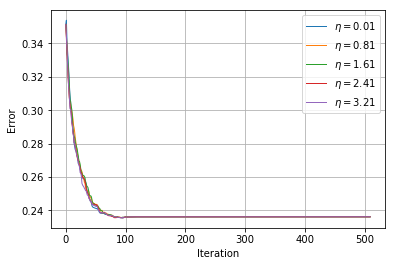

In [63]:
epoch = 2
batch_size = 128
lbda = 0.1
eta_list = np.arange(0.01, 4, 0.8)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
ax.set_ylim(0, 4)

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Error')
ax2.grid()
line_list = []
line_list_2 = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss, val_error = RMSprop_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_2, = ax2.plot(val_error, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_list.append(line)
    line_list_2.append(line)
ax.legend(handles=line_list)
ax2.legend(handles=line_list_2)
plt.show()
fig.savefig('figures/loss_vs_iteation_with_RmsProp_linear_classification.pdf')
fig2.savefig('figures/error_vs_iteation_RmsProp_linear_classification.pdf')

### 4.4 Investigate the sensitiveness of $\eta$ with Adadelta

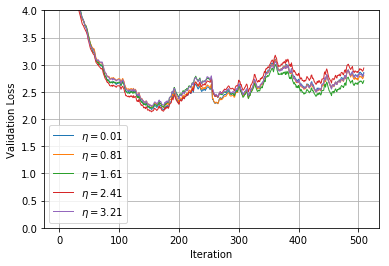

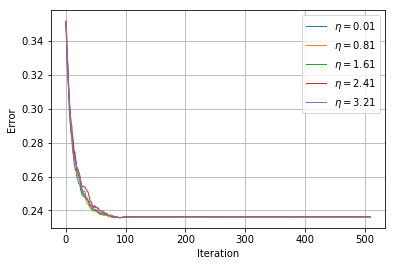

In [64]:
epoch = 2
batch_size = 128
lbda = 0.1
eta_list = np.arange(0.01, 4, 0.8)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
ax.set_ylim(0, 4)

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Error')
ax2.grid()
line_list = []
line_list_2 = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss, val_error = AdaDelta_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_2, = ax2.plot(val_error, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_list.append(line)
    line_list_2.append(line)
ax.legend(handles=line_list)
ax2.legend(handles=line_list_2)
plt.show()
fig.savefig('figures/loss_vs_iteation_with_Adadelta_linear_classification.pdf')
fig2.savefig('figures/error_vs_iteation_Adadelta_linear_classification.pdf')

### 4.5 Investigate the sensitiveness of $\eta$ with Adam

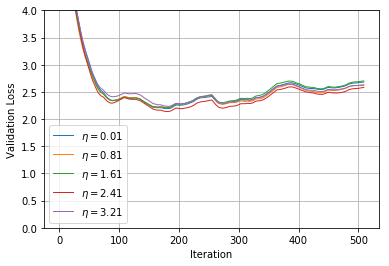

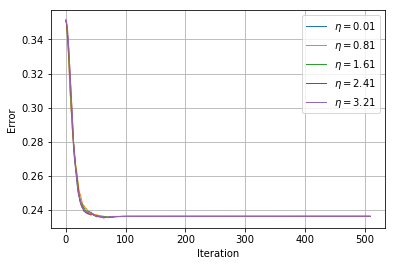

In [65]:
epoch = 2
batch_size = 128
lbda = 0.1
eta_list = np.arange(0.01, 4, 0.8)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
ax.set_ylim(0, 4)

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Error')
ax2.grid()
line_list = []
line_list_2 = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss, val_error = Adam_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_2, = ax2.plot(val_error, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_list.append(line)
    line_list_2.append(line)
ax.legend(handles=line_list)
ax2.legend(handles=line_list_2)
plt.show()
fig.savefig('figures/loss_vs_iteation_with_Adam_linear_classification.pdf')
fig2.savefig('figures/error_vs_iteation_Adam_linear_classification.pdf')

### 4.6 Investigate the performance of different optimization algorithm

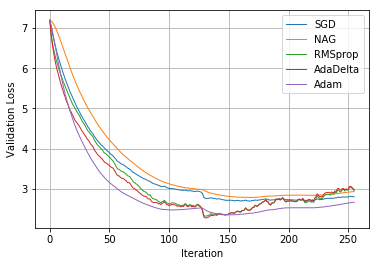

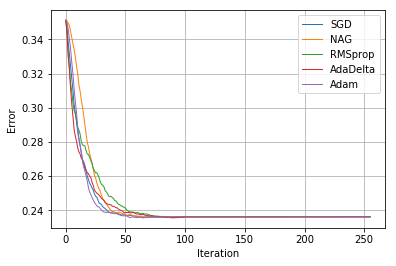

In [59]:
epoch = 2
batch_size = 256
eta_list = np.array([0.01, 1.61, 0.81, 0.81, 0.81])
function_list = [SGD_train, NAG_train, RMSprop_train, AdaDelta_train, Adam_train]
function_name_list = ['SGD', 'NAG', 'RMSprop', 'AdaDelta', 'Adam']

num_eta = eta_list.size
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Error')
ax2.grid()
line_list = []
line_list_2 = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss, val_error = function_list[i](X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label='{}'.format(function_name_list[i]))
    line_2, = ax2.plot(val_error, linewidth=1, label='{}'.format(function_name_list[i]))
    line_list.append(line)
    line_list_2.append(line)
ax.legend(handles=line_list)
ax2.legend(handles=line_list_2)
plt.show()
fig.savefig('figures/loss_vs_iteation_linear_classification.pdf')
fig2.savefig('figures/error_vs_iteation_linear_classification.pdf')